In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
from sklearn.linear_model import LinearRegression


# Data Preprocessing

In [2]:
train_data = pd.read_csv('20220301_20220401_SLD_FCST_N_20220509_22_23_48_v1.csv', index_col=0, parse_dates=[0])
test_data = pd.read_csv('20220401_20220402_SLD_FCST_N_20220509_22_24_12_v1.csv', index_col=0, parse_dates=[0])

In [3]:
train_data = train_data.loc[train_data[
    'TAC_AREA_NAME']=='SCE-TAC'][['TAC_AREA_NAME', 'EXECUTION_TYPE', 'MW']].copy()
test_data = test_data.loc[test_data[
    'TAC_AREA_NAME']=='SCE-TAC'][['TAC_AREA_NAME', 'EXECUTION_TYPE', 'MW']].copy()

In [4]:
print(train_data.isna().sum())
print('---')
print(test_data.EXECUTION_TYPE.value_counts())
print('---')
print(train_data.EXECUTION_TYPE.value_counts())

TAC_AREA_NAME     0
EXECUTION_TYPE    0
MW                0
dtype: int64
---
RTD       288
RTPD       96
7DA        24
ACTUAL     24
2DA        24
DAM        24
Name: EXECUTION_TYPE, dtype: int64
---
RTD       8858
RTPD      2961
2DA        743
7DA        743
DAM        743
ACTUAL     743
Name: EXECUTION_TYPE, dtype: int64


In [5]:
train_data_all = train_data[['EXECUTION_TYPE', 'MW']].pivot(columns='EXECUTION_TYPE', values='MW')
dataset = train_data_all.resample('1H').median()

test_data_all = test_data[['EXECUTION_TYPE', 'MW']].pivot(columns='EXECUTION_TYPE', values='MW')
test_result = test_data_all.resample('1H').median()

actual_demand = test_result['ACTUAL'].values

In [6]:
dataset

EXECUTION_TYPE,2DA,7DA,ACTUAL,DAM,RTD,RTPD
INTERVALSTARTTIME_GMT,,,,,,
2022-03-01 08:00:00+00:00,9170.48,9207.65,9258.0,9275.74,8567.515,8586.745
2022-03-01 09:00:00+00:00,8843.71,8889.96,8965.0,8951.31,8254.700,8239.275
2022-03-01 10:00:00+00:00,8642.64,8709.08,8841.0,8757.20,8083.320,8054.735
2022-03-01 11:00:00+00:00,8604.41,8678.50,8909.0,8709.85,8075.210,8050.115
2022-03-01 12:00:00+00:00,8800.20,8906.38,9190.0,8915.59,8315.265,8278.405
...,...,...,...,...,...,...
2022-04-01 02:00:00+00:00,11272.74,11594.19,11236.0,11148.86,10610.085,10678.015
2022-04-01 03:00:00+00:00,11262.84,11493.63,11085.0,11144.70,10492.275,10558.920
2022-04-01 04:00:00+00:00,10954.64,11212.88,10625.0,10856.43,10164.000,10205.000


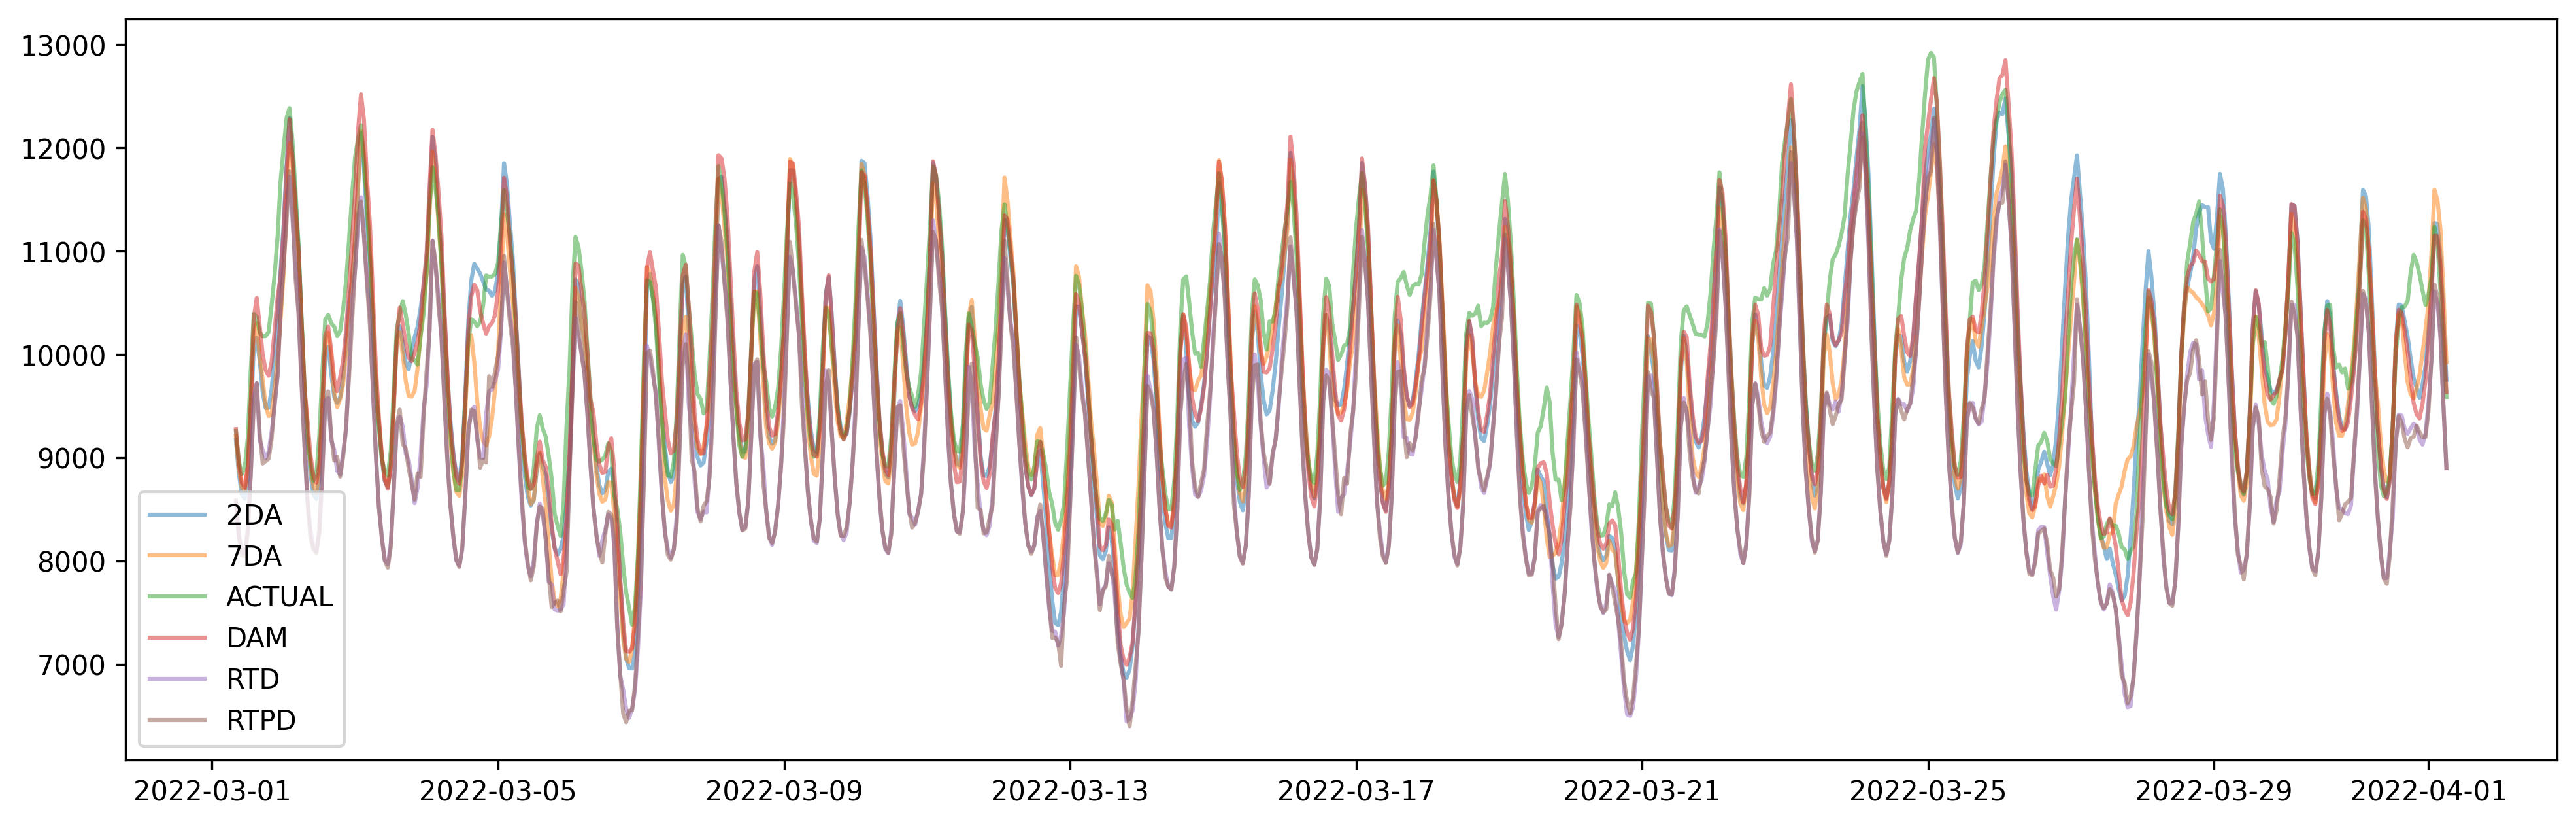

In [7]:
plt.figure(figsize=(16, 5), dpi=300)
for col in dataset.columns:
    plt.plot(dataset[col], label=col, alpha=.5)
plt.legend()
plt.show()

## Evaluate the existing forcast

In [8]:
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)    

In [9]:
rmse_result = {}
for col in dataset.columns:
    comp = rmse(dataset['ACTUAL'], dataset[col])
    print(col + ' RMSE: %.3f' % comp)
    rmse_result[col] = comp

2DA RMSE: 434.469
7DA RMSE: 484.985
ACTUAL RMSE: 0.000
DAM RMSE: 371.914
RTD RMSE: 948.978
RTPD RMSE: 957.156


In [10]:
mape_result = {}
for col in dataset.columns:
    comp = mape(dataset['ACTUAL'], dataset[col])
    print(col + ' MAPE: %.3f' % comp)
    mape_result[col] = comp

2DA MAPE: 3.359
7DA MAPE: 3.478
ACTUAL MAPE: 0.000
DAM MAPE: 2.774
RTD MAPE: 9.190
RTPD MAPE: 9.249


<AxesSubplot:title={'center':'MAPE'}>

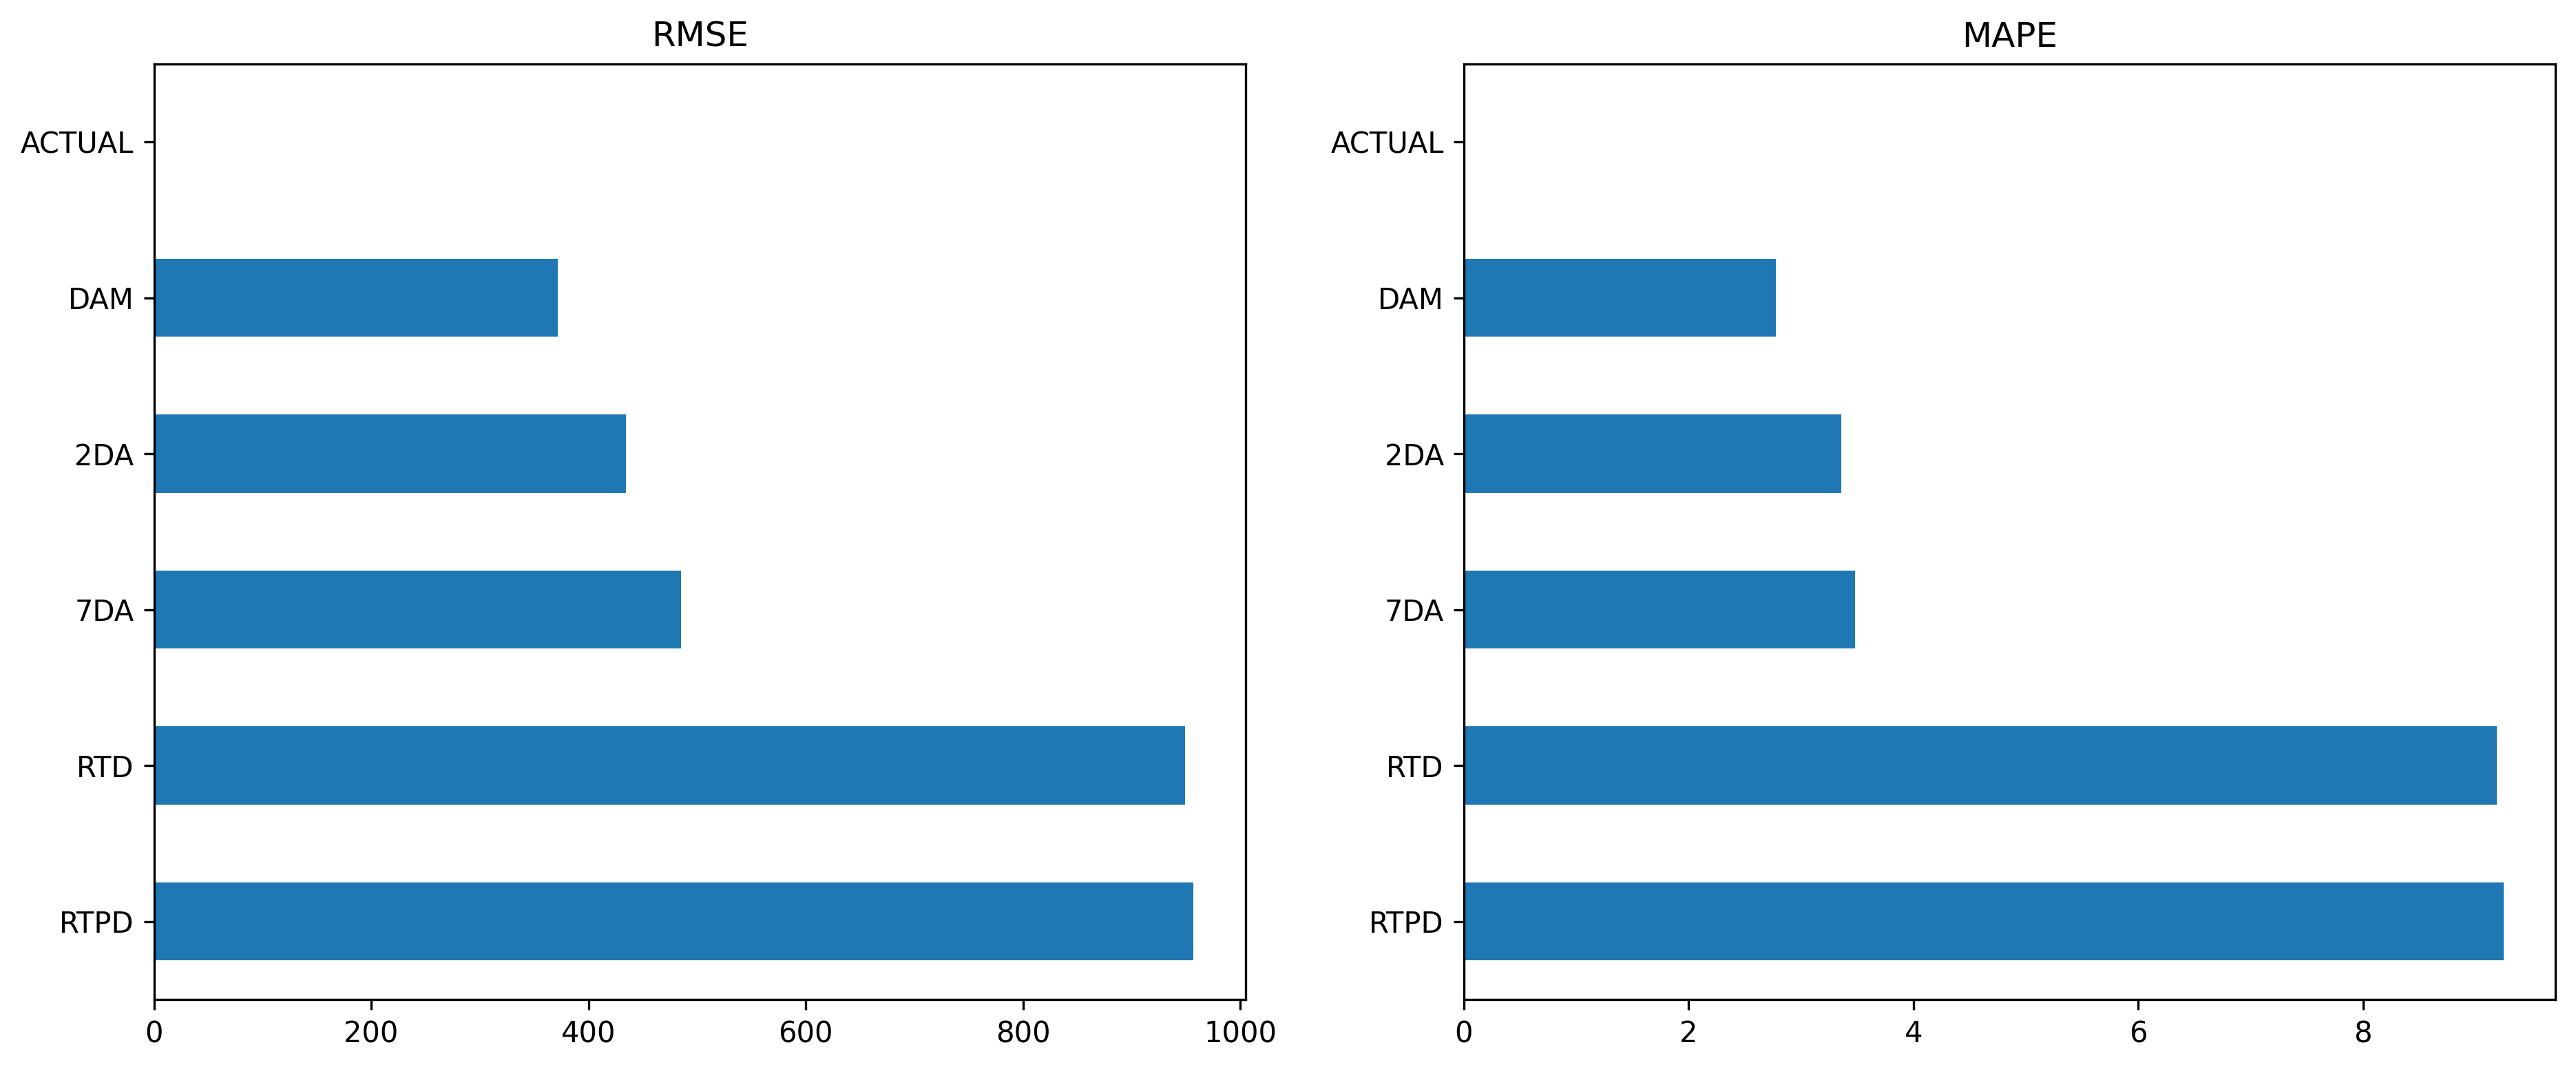

In [11]:
figure, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
rmse_result = pd.DataFrame(rmse_result, index=['VARIABLE', 'VALUE']).T
rmse_result = rmse_result.sort_values(by='VALUE', ascending=False)
rmse_result['VALUE'].plot.barh(ax=axes[0], title='RMSE')
mape_result = pd.DataFrame(mape_result, index=['VARIABLE', 'VALUE']).T
mape_result = mape_result.sort_values(by='VALUE', ascending=False)
mape_result['VALUE'].plot.barh(ax=axes[1], title='MAPE')

In [12]:
print('Baseline: MAPE of DAM on 04/01/2022: %.4f' % mape(actual_demand, test_result['DAM'].values))

Baseline: MAPE of DAM on 04/01/2022: 5.2267


# Model

## Regression

In [13]:
dataset_linear = dataset.copy()
dataset_linear['ACTUAL_24h'] = dataset_linear['ACTUAL'].shift(-24)

In [14]:
X = dataset_linear.dropna().drop(columns='ACTUAL_24h').values
y = dataset_linear.dropna()['ACTUAL_24h'].values
reg = LinearRegression().fit(X, y)

In [15]:
X_test = dataset_linear.tail(24).drop(columns='ACTUAL_24h').values
y_pred_linear = reg.predict(X_test)

In [16]:
print('MAPE of linear regression: %.4f' % mape(actual_demand, y_pred_linear))

MAPE of linear regression: 3.1629


## LSTM

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional
from tensorflow.keras import Input

input_shape = (24, 6)
layer_size = 64
patience = 10
max_epochs = 100
train_set_split = .8

def make_dataset(data, target_column, prediction_offset=-24, targets=True, shuffle=True):
    input_data = data.iloc[:prediction_offset].values
    if targets:
        target_data = data[target_column].iloc[-prediction_offset:].values
    else:
        target_data = None
    dt = tf.keras.utils.timeseries_dataset_from_array(
        data=input_data,
        targets=target_data,
        sequence_length=24,
        shuffle=shuffle,
        batch_size=32)
    return dt

# normalize dataset
X_df = dataset.copy()
X_mean, X_std = X_df.mean(), X_df.std()
X_df = (X_df - X_mean) / X_std

train_size = int(len(X_df) * train_set_split)
train_df = make_dataset(X_df.iloc[:train_size], target_column='ACTUAL')
val_df = make_dataset(X_df.iloc[train_size:], target_column='ACTUAL')
test_df = make_dataset(
    X_df.tail(24+24-1), prediction_offset=None, 
    target_column='ACTUAL', shuffle=False, targets=False)

2022-05-22 19:43:27.538555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Vanilla LSTM
A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.



In [18]:
# model = Sequential()
# model.add(LSTM(layer_size, activation='relu', input_shape=input_shape, return_sequences=False))
# model.add(Dense(1))

### Stacked LSTM
Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

In [19]:
model = Sequential()
model.add(LSTM(layer_size, activation='relu', input_shape=input_shape, return_sequences=True))
model.add(LSTM(layer_size, activation='relu', return_sequences=False))
model.add(Dense(1))

### Bidirectional LSTM
On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

In [20]:
# model = Sequential()
# model.add(Bidirectional(LSTM(layer_size, activation='relu'), input_shape=input_shape))
# model.add(Dense(1))

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min',
                                                  restore_best_weights=True)

model.compile(loss=tf.losses.MeanAbsoluteError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_df, epochs=max_epochs,
                    validation_data=val_df,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 [==============================] - 3s 43ms/step - loss: 0.8072 - mean_absolute_error: 0.8072 - val_loss: 0.6386 - val_mean_absolute_error: 0.6386
Epoch 2/100
18/18 [==============================] - 0s 19ms/step - loss: 0.4684 - mean_absolute_error: 0.4684 - val_loss: 0.2794 - val_mean_absolute_error: 0.2794
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 0.2076 - mean_absolute_error: 0.2076 - val_loss: 0.1792 - val_mean_absolute_error: 0.1792
Epoch 4/100
18/18 [==============================] - 0s 20ms/step - loss: 0.1841 - mean_absolute_error: 0.1841 - val_loss: 0.2239 - val_mean_absolute_error: 0.2239
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 0.2096 - mean_absolute_error: 0.2096 - val_loss: 0.1844 - val_mean_absolute_error: 0.1844
Epoch 6/100
18/18 [==============================] - 0s 18ms/step - loss: 0.1673 - mean_absolute_error: 0.1673 - val_loss: 0.1889 - val_mean_absolute_error: 0.1889
Epoch 7/100
18/1

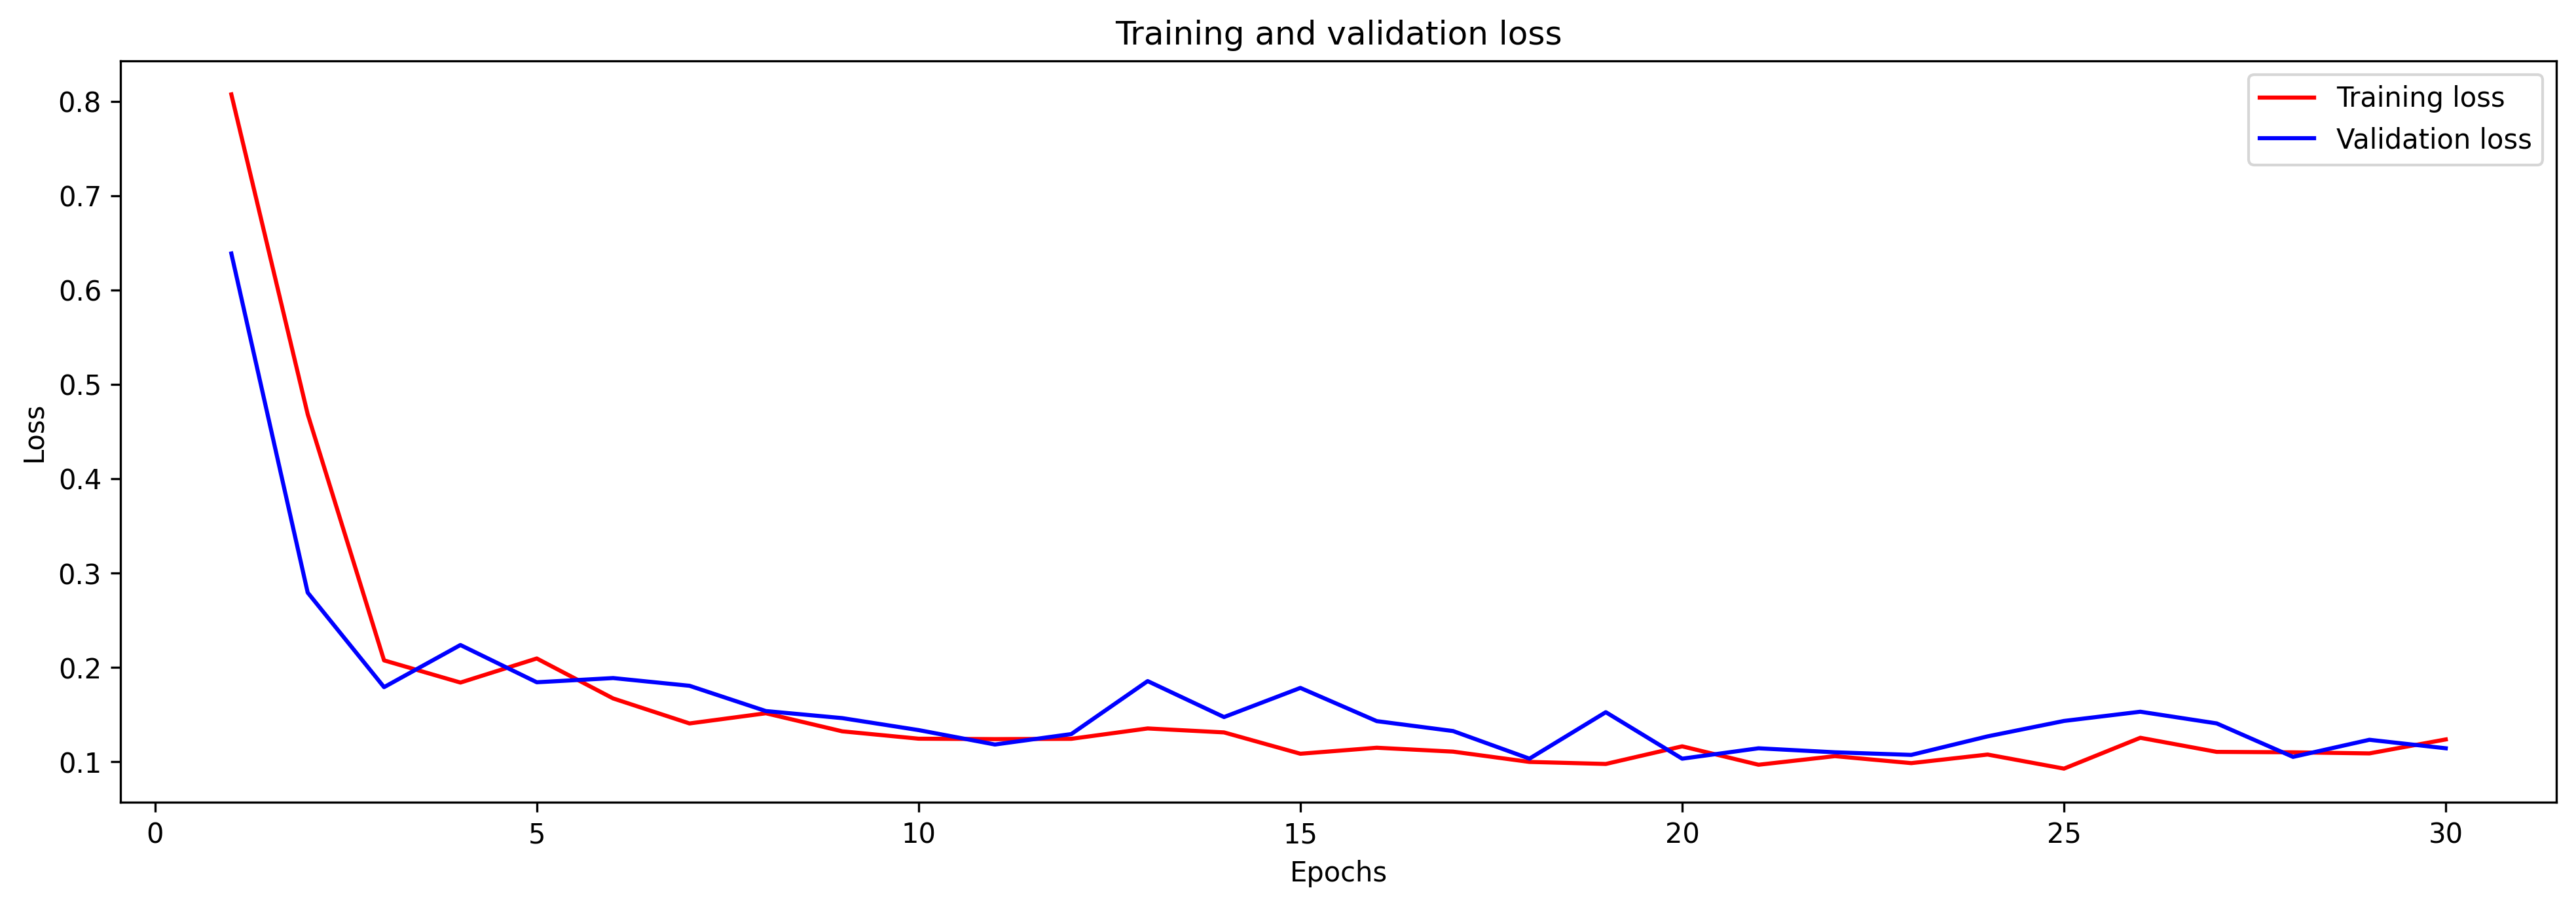

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [23]:
y_pred_lstm = np.array(model.predict(test_df)).flatten()*X_std['ACTUAL']+X_mean['ACTUAL']

In [24]:
print('MAPE of LSTM: %.4f' % mape(actual_demand, y_pred_lstm))

MAPE of LSTM: 3.5701


### ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


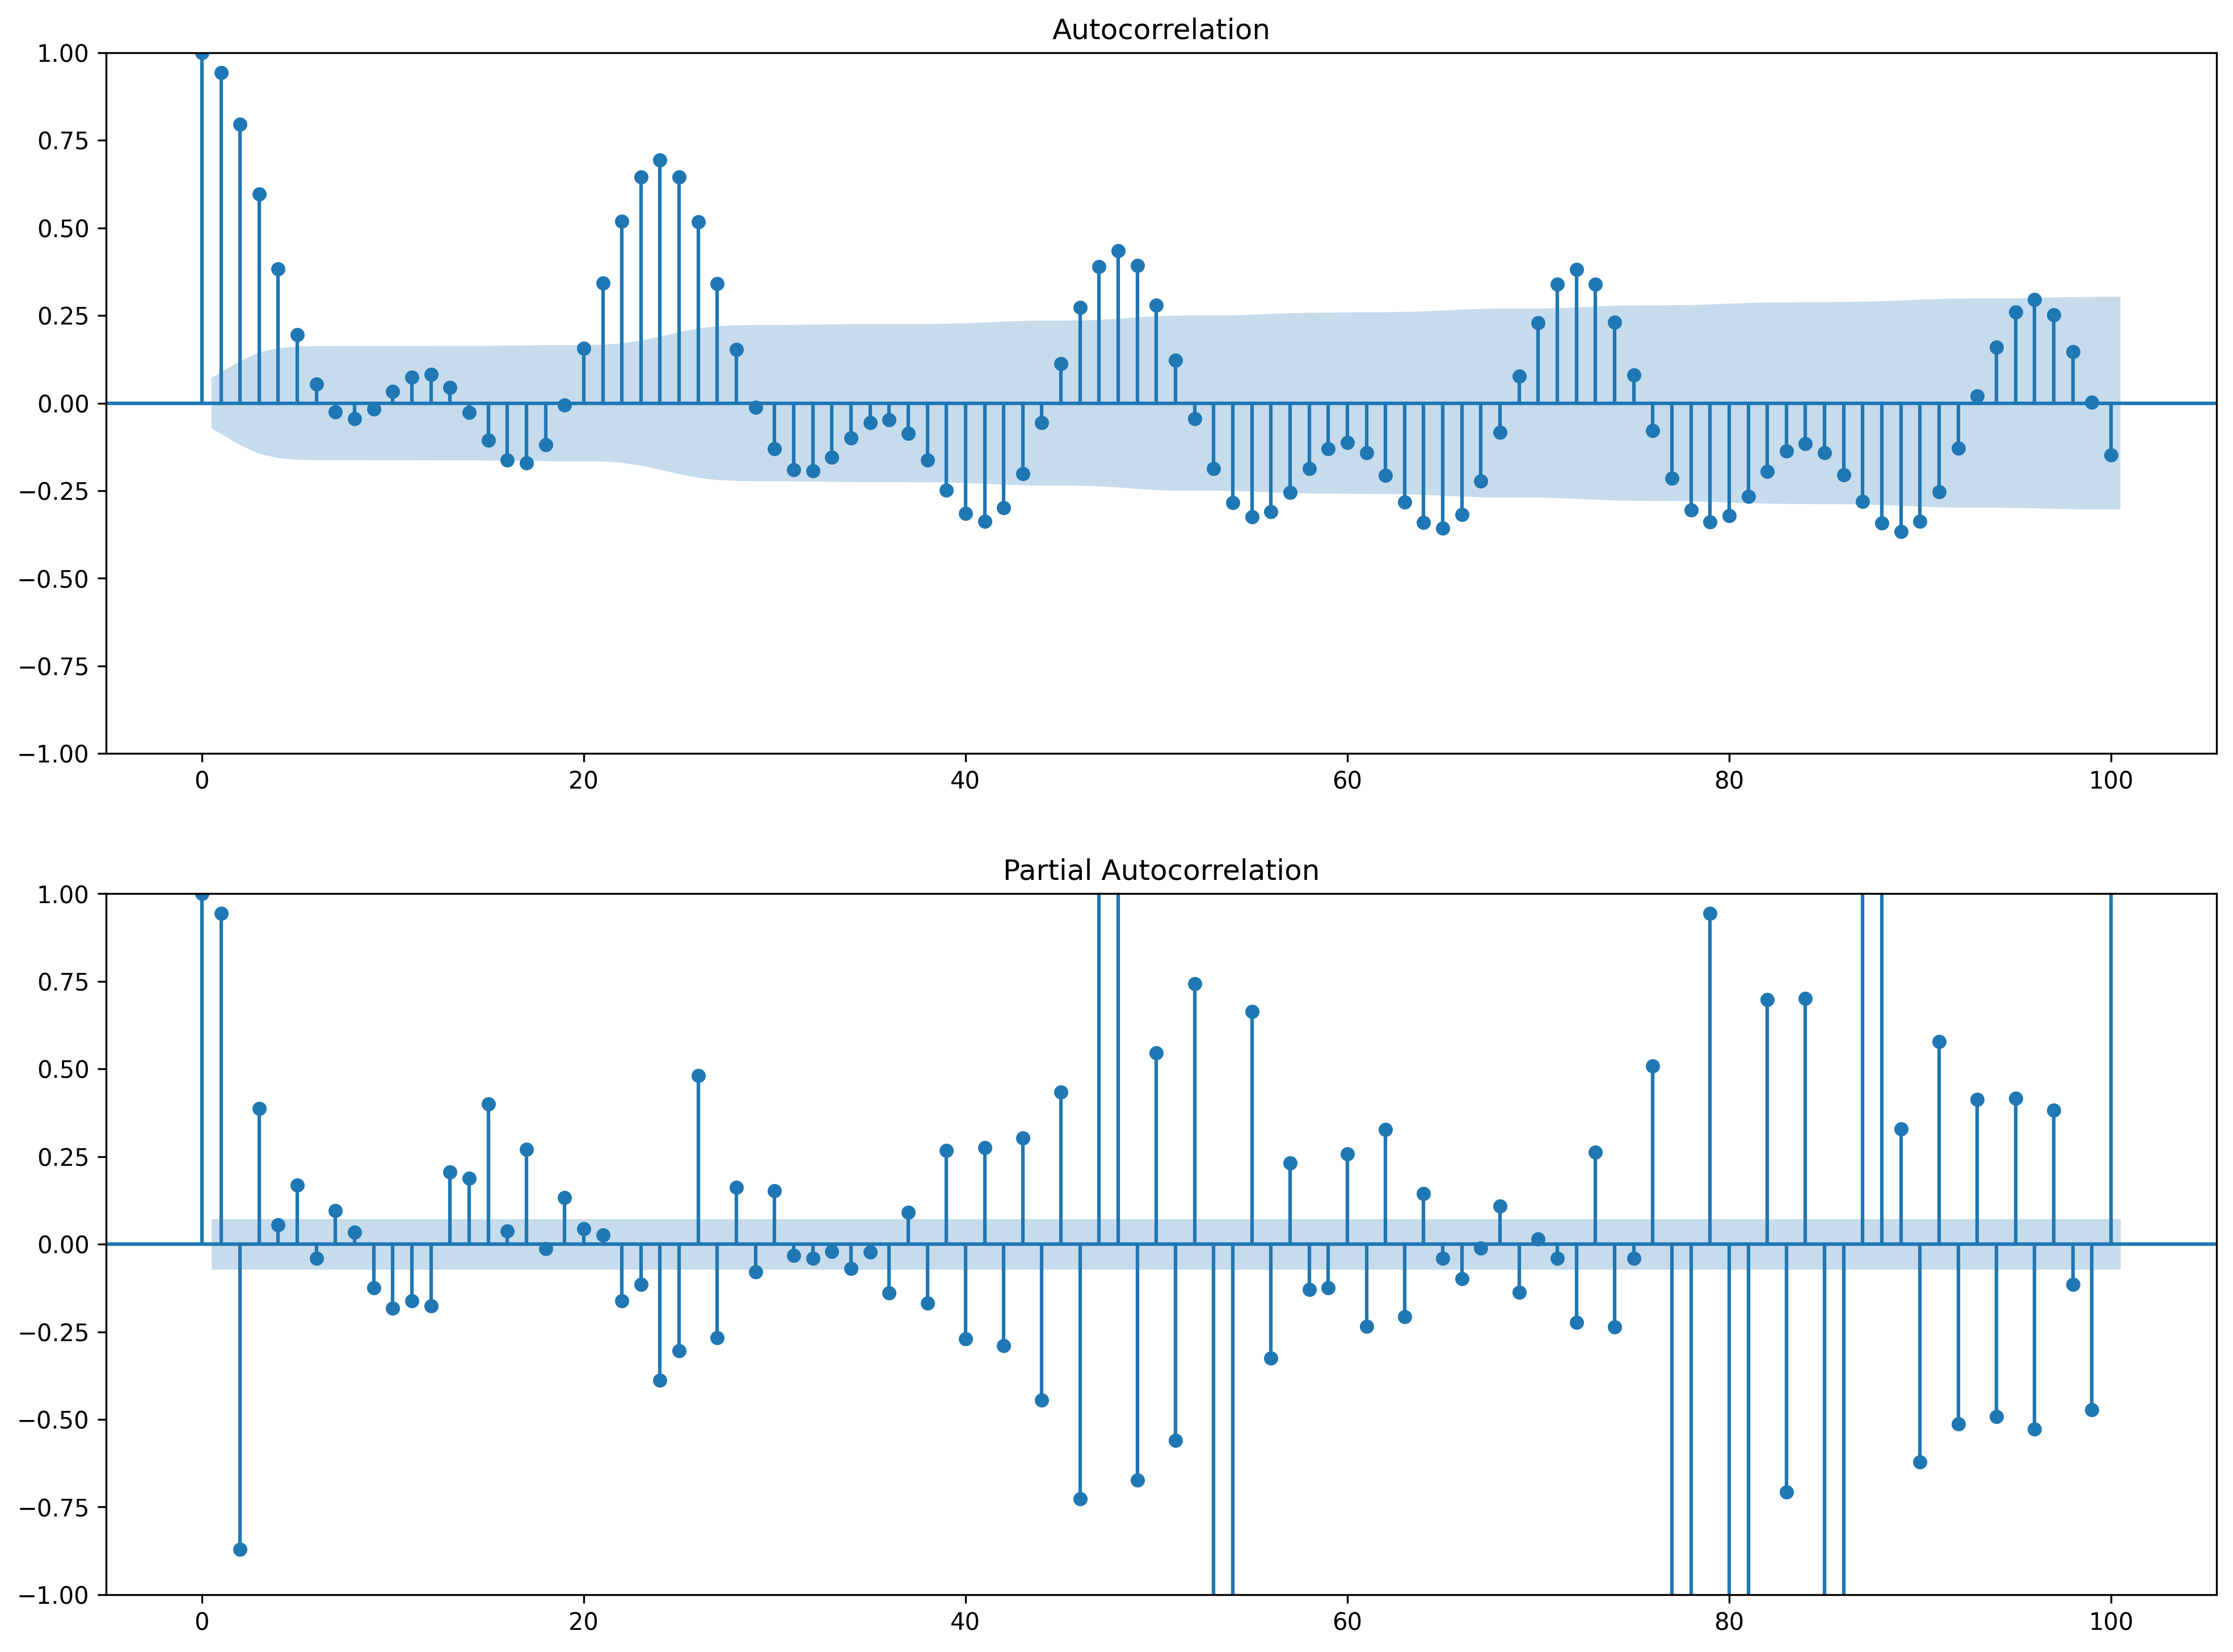

In [26]:
fig = plt.figure(figsize=(16, 12), dpi=300)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset['ACTUAL'], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset['ACTUAL'], lags=100, ax=ax2)

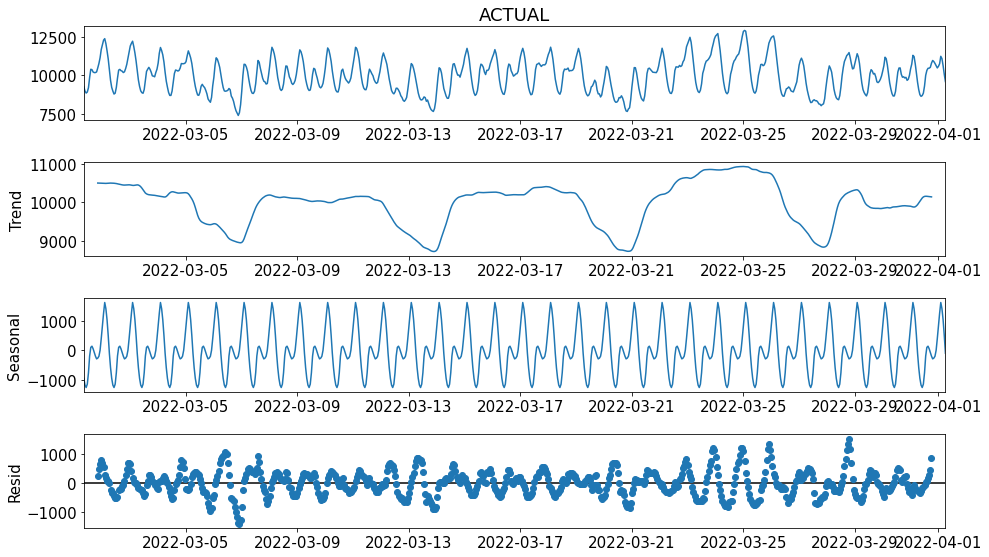

In [35]:
plt.rc('figure', figsize=(14, 8))
plt.rc('font', size=15)

result = seasonal_decompose(dataset['ACTUAL'], model='additive')
fig = result.plot()

In [32]:
check_stationarity(dataset['ACTUAL'])

The series is NOT stationary


### ARIMA

In [38]:
def tune_model(dataset, p_values, d_values, q_values, actual_demand):
    min_MAPE = float('Inf')
    for p in p_values:
        for d in d_values:
            for q in q_values:
                model = ARIMA(dataset, order=(p, d, q))
                arima_fit = model.fit()
                y_pred_arima_pqd = arima_fit.forecast(24)
                MAPE = mape(actual_demand, y_pred_arima_pqd)
#                 print('MAPE of ARIMA(%d, %d, %d): %.4f' % (p, d, q, MAPE))
                if min_MAPE > MAPE:
                    best_p = p
                    best_d = d
                    best_q = q
                    min_MAPE = MAPE
    print('---')
    print('Best model is ARIMA(%d, %d, %d), with MAPE: %.4f' % (best_p, best_d, best_q, min_MAPE))

In [43]:
tune_model(
    dataset['ACTUAL'].values, 
    [1, 2, 3, 4, 8, 12],
    [0, 1],
    [1, 2, 3, 4, 8, 12],
    actual_demand
)

MAPE of ARIMA(1, 0, 1): 6.2726
MAPE of ARIMA(1, 0, 2): 5.9585
MAPE of ARIMA(1, 0, 3): 5.7111
MAPE of ARIMA(1, 0, 4): 5.3422


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(1, 0, 8): 5.4512


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(1, 0, 12): 4.7386
MAPE of ARIMA(1, 1, 1): 14.2869
MAPE of ARIMA(1, 1, 2): 13.3270
MAPE of ARIMA(1, 1, 3): 10.0854
MAPE of ARIMA(1, 1, 4): 5.8059
MAPE of ARIMA(1, 1, 8): 5.0617


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(1, 1, 12): 3.8058
MAPE of ARIMA(2, 0, 1): 4.4720
MAPE of ARIMA(2, 0, 2): 4.4288
MAPE of ARIMA(2, 0, 3): 4.5884
MAPE of ARIMA(2, 0, 4): 4.5667


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(2, 0, 8): 4.2332


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(2, 0, 12): 3.6349
MAPE of ARIMA(2, 1, 1): 4.4909
MAPE of ARIMA(2, 1, 2): 4.1085
MAPE of ARIMA(2, 1, 3): 6.9063
MAPE of ARIMA(2, 1, 4): 6.7582


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(2, 1, 8): 4.0290


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(2, 1, 12): 3.6851
MAPE of ARIMA(3, 0, 1): 4.4086
MAPE of ARIMA(3, 0, 2): 4.4988


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 0, 3): 5.0358


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 0, 4): 4.6310


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 0, 8): 4.3135


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 0, 12): 4.1200
MAPE of ARIMA(3, 1, 1): 4.1116
MAPE of ARIMA(3, 1, 2): 4.2934


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 1, 3): 6.2311


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 1, 4): 8.8969


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 1, 8): 4.5256


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(3, 1, 12): 3.4828
MAPE of ARIMA(4, 0, 1): 4.4663


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 0, 2): 4.4725
MAPE of ARIMA(4, 0, 3): 4.4749


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 0, 4): 3.3634


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 0, 8): 2.1231


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 0, 12): 2.3049
MAPE of ARIMA(4, 1, 1): 4.7919
MAPE of ARIMA(4, 1, 2): 4.1460


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 1, 3): 4.4178


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 1, 4): 5.7028


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 1, 8): 4.3036


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(4, 1, 12): 3.7066
MAPE of ARIMA(8, 0, 1): 4.4387
MAPE of ARIMA(8, 0, 2): 4.3792


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 0, 3): 4.3526


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 0, 4): 4.3682


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 0, 8): 3.3464


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 0, 12): 2.2199
MAPE of ARIMA(8, 1, 1): 5.4393


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 1, 2): 8.3309


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 1, 3): 5.2107


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 1, 4): 5.1596


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 1, 8): 7.2202


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(8, 1, 12): 4.4645
MAPE of ARIMA(12, 0, 1): 4.9266
MAPE of ARIMA(12, 0, 2): 4.9864


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 0, 3): 4.8870


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 0, 4): 4.1997


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 0, 8): 3.9326


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 0, 12): 1.6853


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 1, 1): 2.6285


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 1, 2): 3.0767


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 1, 3): 2.7924


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 1, 4): 8.2576


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MAPE of ARIMA(12, 1, 8): 3.9870
MAPE of ARIMA(12, 1, 12): 1.4576
---
Best model is ARIMA(12, 1, 12), with MAPE: 1.4576


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [69]:
model = ARIMA(dataset['ACTUAL'].values, order=(12, 1, 12))
arima_fit = model.fit()
arima_fit.summary()

/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  743
Model:               ARIMA(12, 1, 12)   Log Likelihood               -4697.743
Date:                Sun, 22 May 2022   AIC                           9445.485
Time:                        20:50:42   BIC                           9560.719
Sample:                             0   HQIC                          9489.910
                                - 743                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9024      0.074     12.239      0.000       0.758       1.047
ar.L2          0.4552      0.128      3.561      0.000       0.205       0.706
ar.L3         -0.5176      0.115     -4.496      0.000      -0.743      -0.292
ar.L4         -0.2881      0.115     -2.505      0.012      -0.514      -0.063
ar.L5         -0.0920      0.093     -0.986      0.324      -0.275       0.091
ar.L6          0.4754      0.097      4.905      0.000       0.285       0.665
ar.L7          0.1006      0.093      1.077      0.281      -0.082       0.284
ar.L8         -0.8099      0.089     -9.144      0.000      -0.983      -0.636
ar.L9         -0.0232      0.122     -0.190      0.849      -0.262       0.216
ar.L10         0.5546      0.123      4.511      0.000       0.314       0.796
ar.L11         0.4468      0.112      3.994      0.000       0.228       0.666
ar.L12        -0.7385      0.062    -11.980      0.000      -0.859      -0.618
ma.L1         -0.3554      0.076     -4.650      0.000      -0.505      -0.206
ma.L2         -0.7497      0.093     -8.081      0.000      -0.932      -0.568
ma.L3          0.3023      0.083      3.658      0.000       0.140       0.464
ma.L4          0.4199      0.086      4.895      0.000       0.252       0.588
ma.L5          0.0956      0.072      1.331      0.183      -0.045       0.236
ma.L6         -0.3194      0.066     -4.866      0.000      -0.448      -0.191
ma.L7         -0.2592      0.064     -4.065      0.000      -0.384      -0.134
ma.L8          0.6200      0.069      9.003      0.000       0.485       0.755
ma.L9          0.3744      0.098      3.810      0.000       0.182       0.567
ma.L10        -0.6194      0.084     -7.354      0.000      -0.784      -0.454
ma.L11        -0.4781      0.075     -6.356      0.000      -0.625      -0.331
ma.L12         0.5012      0.053      9.452      0.000       0.397       0.605
sigma2      2.196e+04   1500.599     14.635      0.000     1.9e+04    2.49e+04
===================================================================================
Ljung-Box (L1) (Q):                   6.79   Jarque-Bera (JB):                 5.99
Prob(Q):                              0.01   Prob(JB):                         0.05
Heteroskedasticity (H):               0.96   Skew:                             0.21
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
y_pred_arima = arima_fit.forecast(24)
print('MAPE of ARIMA: %.4f' % mape(actual_demand, y_pred_arima))
print('RMSE of ARIMA: %.4f' % rmse(actual_demand, y_pred_arima))


MAPE of ARIMA: 1.4576
RMSE of ARIMA: 184.5320


### Seasonal ARIMA

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
best_model = SARIMAX(dataset['ACTUAL'], order=(12, 1, 12), seasonal_order=(3, 0, 1, 24))
arima_fit = best_model.fit()
# arima_fit.summary()

/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64985D+00    |proj g|=  5.59139D-01

At iterate    5    f=  6.27272D+00    |proj g|=  7.22845D-02

At iterate   10    f=  6.24556D+00    |proj g|=  3.04296D-02

At iterate   15    f=  6.24015D+00    |proj g|=  1.21496D-02

At iterate   20    f=  6.23914D+00    |proj g|=  8.56603D-03

At iterate   25    f=  6.23822D+00    |proj g|=  6.38579D-03

At iterate   30    f=  6.23605D+00    |proj g|=  7.23326D-02

At iterate   35    f=  6.23448D+00    |proj g|=  8.33347D-02

At iterate   40    f=  6.23285D+00    |proj g|=  9.24462D-02

At iterate   45    f=  6.23128D+00    |proj g|=  1.89377D-02


/Users/mac/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f=  6.22989D+00    |proj g|=  5.65978D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     58      1     0     0   5.660D-02   6.230D+00
  F =   6.2298878599561043     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [67]:
y_pred_sarima = arima_fit.forecast(24)
print('MAPE of SARIMA: %.4f' % mape(actual_demand, y_pred_sarima))
print('RMSE of SARIMA: %.4f' % rmse(actual_demand, y_pred_sarima))


MAPE of SARIMA: 1.4485
RMSE of SARIMA: 201.6864


# Visualization

<AxesSubplot:xlabel='INTERVALSTARTTIME_GMT'>

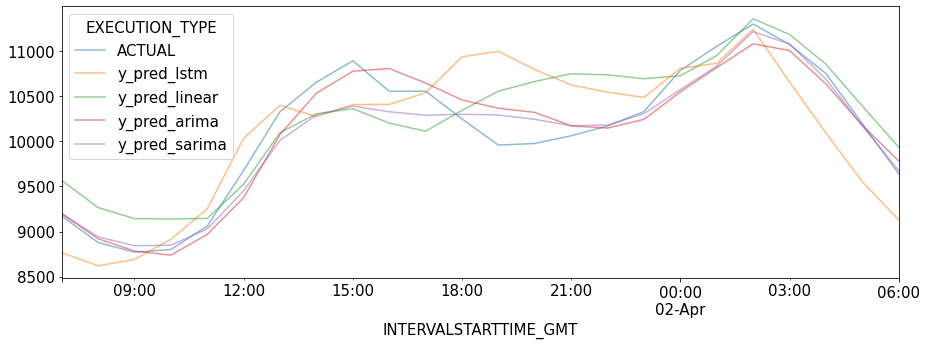

In [64]:
test_result['y_pred_linear'] = y_pred_linear
test_result['y_pred_lstm'] = y_pred_lstm
test_result['y_pred_arima'] = y_pred_arima
test_result['y_pred_sarima'] = y_pred_sarima
test_result[['ACTUAL','y_pred_lstm','y_pred_linear', 'y_pred_arima', 'y_pred_sarima']].plot(
    figsize=(15,5), alpha=0.5)